In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer


In [3]:
data_set = pd.read_excel('Data/Segmentacion_CATT.xlsx',sheet_name=0).fillna(0)

In [4]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   negocio                     144 non-null    object 
 1   region                      144 non-null    object 
 2   canal                       144 non-null    int64  
 3   capturas_tarjetas           144 non-null    float64
 4   aprobacion_tarjetas         144 non-null    float64
 5   tarjetas                    144 non-null    float64
 6   capturas_creditos           144 non-null    float64
 7   aprobacion_creditos         144 non-null    float64
 8   cantidad_creditos           144 non-null    float64
 9   monto_creditos              144 non-null    float64
 10  seguros                     144 non-null    float64
 11  trafico_transaccional       144 non-null    float64
 12  trafico_clientes            144 non-null    float64
 13  aprovechamiento_de_trafico  144 non

In [10]:
len(data_set.canal.unique())

141

In [44]:
data_set.columns

Index(['negocio', 'region', 'canal', 'capturas_tarjetas',
       'aprobacion_tarjetas', 'tarjetas', 'capturas_creditos',
       'aprobacion_creditos', 'cantidad_creditos', 'monto_creditos', 'seguros',
       'trafico_transaccional', 'trafico_clientes',
       'aprovechamiento_de_trafico', 'contribucion'],
      dtype='object')

In [45]:
data_set = data_set[[
    'canal','capturas_tarjetas',
       'aprobacion_tarjetas', 'tarjetas', 'capturas_creditos',
       'aprobacion_creditos', 'cantidad_creditos', 'monto_creditos', 'seguros',
       'trafico_transaccional', 'trafico_clientes',
       'aprovechamiento_de_trafico', 'contribucion'
]]

In [46]:
# Seleccionar columnas numéricas y la categórica 'region'
features_numeric = [
    'capturas_tarjetas',
       'aprobacion_tarjetas', 'tarjetas', 'capturas_creditos',
       'aprobacion_creditos', 'cantidad_creditos', 'monto_creditos', 'seguros',
       'trafico_transaccional', 'trafico_clientes',
       'aprovechamiento_de_trafico', 'contribucion'
]
features_categorical = ['canal']

# Construir un preprocesador: escalado para numéricos, OneHot para categóricos
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), features_numeric),
    ('cat', OneHotEncoder(sparse_output=False, drop='first'), features_categorical)
])

## Clustering

### Usare dos metodos para obtener el numero de clusteres optimos

#### Método silhouette:
Conclusión: El mejor valor de 𝐾 es 3 clusters, ya que tiene el mayor silhouette score (0.2505), lo que sugiere una segmentación razonablemente bien definida.

In [47]:
X_processed = preprocessor.fit_transform(data_set)
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    silhouette_scores.append((k, score))

silhouette_scores

[(2, np.float64(0.2371558183110123)),
 (3, np.float64(0.2505805289319891)),
 (4, np.float64(0.23754309427377482)),
 (5, np.float64(0.24312576542400283)),
 (6, np.float64(0.2476618455085483)),
 (7, np.float64(0.232190967668337)),
 (8, np.float64(0.2044337079819742)),
 (9, np.float64(0.215820746431835)),
 (10, np.float64(0.21807174834123955))]

#### Método Codo
Conclusión: Confirma lo anterior el mejor K = 3 el más óptimo. 

In [18]:
randonseed = 20

Text(0, 0.5, 'd[Inertia]')

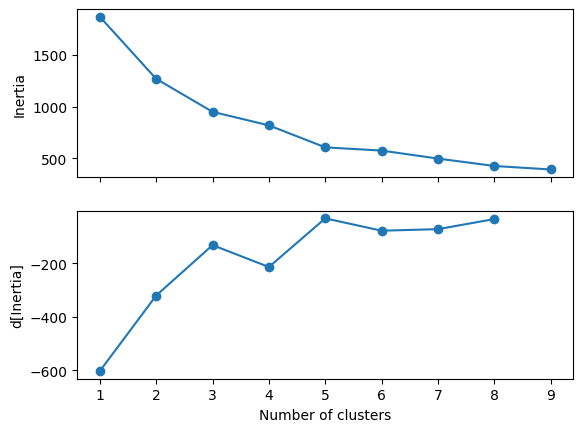

In [19]:
clusters = range(1, 10, 1)
inertias = []

X = StandardScaler().fit_transform(data_set)

for n in clusters:
    k = KMeans(n_clusters=n, random_state=randonseed)
    k.fit(X)
    inertias.append(k.inertia_)
    
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.plot(clusters, inertias, '-o')
ax2.plot(clusters[:-1], np.diff(inertias), '-o')

ax2.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax2.set_ylabel('d[Inertia]')

### Modelo Kmeans 

In [20]:
X =StandardScaler().fit_transform(data_set)
num_clusters = 3
k = KMeans(n_clusters=num_clusters, random_state=randonseed)
k.fit(X)
y = k.predict(X)
#Reduccion de componentes
pca = PCA(n_components=num_clusters,random_state=randonseed).fit(X)

X_ = pca.transform(X)

dataset = data_set.assign(
    cluster=y
)
dataset['cluster'].value_counts()

cluster
0    75
1    40
2    29
Name: count, dtype: int64

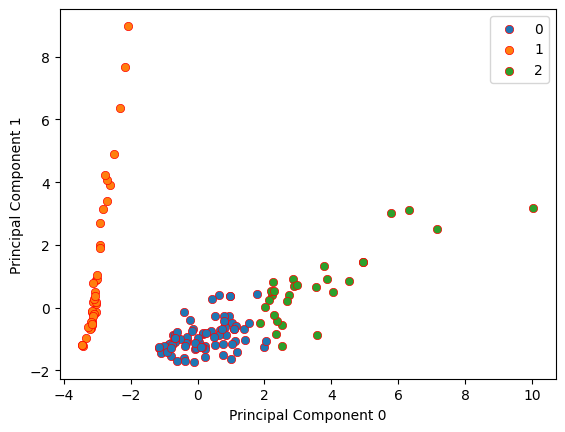

In [21]:
componente_x = min(0, num_clusters - 1)
componente_y = min(1, num_clusters - 1)

fig, ax = plt.subplots()

for cluster, group in dataset.groupby('cluster'):
    ax.scatter(
        X_[group.index, componente_x], 
        X_[group.index, componente_y], 
        #c=y, 
        edgecolor='red', 
        label=cluster,
        lw=0.5, 
        alpha=1
    )

ax.set_xlabel('Principal Component '+str(componente_x))
ax.set_ylabel('Principal Component '+str(componente_y))

ax.legend()
plt.show()

In [22]:
pd.set_option('display.max_rows', 120)
df_clusters = dataset.groupby(
    by='cluster'
).mean().T

df_clusters

cluster,0,1,2
canal,410433.186667,5.005003e+07,364765.586207
capturas_tarjetas,295.713333,8.292875e+02,841.905172
aprobacion_tarjetas,0.212435,1.916680e-01,0.226356
tarjetas,55.650000,1.656750e+02,172.198276
capturas_creditos,104.350000,6.250000e-03,289.318966
aprobacion_creditos,0.029739,0.000000e+00,0.038821
cantidad_creditos,8.113333,0.000000e+00,29.344828
monto_creditos,21.424917,0.000000e+00,80.162884
seguros,53.510000,0.000000e+00,177.172414
trafico_transaccional,69821.090000,0.000000e+00,108025.965517


In [24]:
dataset.to_csv('Data/result_segmentacion.csv')